In [15]:
%load_ext autoreload
%autoreload 2
import xgboost as xgb
import pandas as pd
import numpy as np
from utils import k_fold_cross_validation_classification, acc_pre_rec

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
df_train = pd.read_csv('data/xgboost_distance_regression_merged_train')
df_test = pd.read_csv('data/xgboost_distance_regression_merged_test')


df_train = df_train[df_train['mode'] != np.nan]

df = pd.concat((df_train, df_test), ignore_index=True)
string_cols = ['survey_language', 'disability']
df[string_cols] = df[string_cols].astype('category')
df[string_cols] = df[string_cols].apply(lambda x: x.cat.codes)



In [9]:
df_train

,id,person_id,trip_n,travel_date,travel_date_dow,o_purpose_category,d_purpose_category,num_non_hh_travelers,num_hh_travelers,num_travelers,...,num_students,disability,trip_distance,mode,trip_distance_category,age_merged,income_aggregate_merged,res_type_merged,education_merged,travel_date_dow_merged
0,0,0,0,30/05/2019,4,7,2,0,1,1,...,2,3,3.735712,subway,long,1,1,0,1,0
1,1,0,1,01/06/2019,6,6,1,0,1,1,...,2,3,2.708090,drive,long,1,1,0,1,1
2,2,0,2,02/06/2019,7,7,7,1,2,3,...,2,3,2.622690,drive,long,1,1,0,1,1
3,3,0,3,02/06/2019,7,7,7,1,2,3,...,2,3,2.622690,drive,long,1,1,0,1,1
4,4,0,4,03/06/2019,1,7,7,0,1,1,...,2,3,2.192609,drive,medium,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39439,39493,1794,53,07/06/2019,5,6,6,0,2,2,...,0,3,1.227500,walk,short,1,0,2,1,0
39440,39494,1794,54,07/06/2019,5,6,6,0,2,2,...,0,3,1.227500,walk,short,1,0,2,1,0
39441,39495,1794,55,07/06/2019,5,6,6,0,2,2,...,0,3,1.227500,walk,short,1,0,2,1,0
39442,39496,1794,56,07/06/2019,5,6,8,0,2,2,...,0,3,1.852256,walk,medium,1,0,2,1,0


In [3]:
TRANSPORT_MODES = ['drive', 'passenger', 'bus', 'subway', 'bike', 'walk', 'other']
candidate_cols = [
#      'travel_date_dow',
     'o_purpose_category',
     'd_purpose_category',
     'num_non_hh_travelers',
     'num_hh_travelers',
     'num_travelers',
#      'o_location_type',
#      'd_location_type',
     'o_congestion',
     'd_congestion',
#      'age',
#      'employment',
#      'student',
     'license',
#      'planning_apps',
#      'industry',
#      'gender',
#      'education',
#      'survey_language',
#      'num_bicycles',
     'num_vehicles',
#      'res_type',
#      'rent_own',
#      'income_aggregate',
#      'num_people',
#      'num_adults',
#      'num_kids',
#      'num_workers',
#      'num_students',
#      'disability'
    'trip_distance',
    'res_type_merged',
    'income_aggregate_merged',
    'age_merged',
    'travel_date_dow_merged',
    'education_merged']

categorial_columns = ['travel_date_dow',
       'o_purpose_category', 'd_purpose_category', 'o_location_type',
       'd_location_type', 'age', 'employment', 'license', 'planning_apps', 'industry', 'gender'
                    , 'survey_language',
       'res_type', 'rent_own',  'disability']

onehot = pd.get_dummies(df[candidate_cols], columns=[x for x in categorial_columns if x in candidate_cols])

X_train_val = onehot.to_numpy()[:len(df_train)]
y_train_val = df['mode'][:len(df_train)].apply(lambda x: TRANSPORT_MODES.index(x))
group = df['person_id'].to_numpy()[:len(df_train)]

X_test = onehot.to_numpy()[len(df_train):]



XGBoost parameters: https://xgboost.readthedocs.io/en/stable/parameter.html

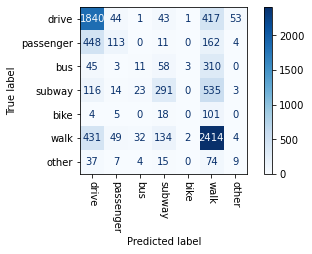

In [22]:
model = xgb.XGBClassifier(objective='multi:softprob',
                          n_estimators = 100,
                          n_jobs=-1,
                          learning_rate=0.138,
                          num_class=7,
                          random_state=42,
                          eval_metric=['mlogloss', 'merror'],
                          use_label_encoder =False)


train_metrics, val_metrics = k_fold_cross_validation_classification(X_train_val,
                                                                    y_train_val,
                                                                    group,
                                                                    model,
                                                                    confusion_matrix_save_path='image/xgboost_mode_confusion.eps',
                                                                    display_labels=TRANSPORT_MODES)

In [5]:
train_metrics

[(0.6731421327840279, 0.8630269858080052),
 (0.6713991443511329, 0.8651673144786769),
 (0.6731738234828077, 0.8647172597455485),
 (0.6784978608778324, 0.8452350771119557),
 (0.6708074534161491, 0.863415800619777)]

In [6]:
metrics = np.concatenate((train_metrics, val_metrics), axis=1)
metrics = metrics[:,[0, 2, 1, 3]]

df_metrics = pd.DataFrame(metrics, columns=['acc-train', 'acc-val', 'cross entropy-train', 'cros entropy-val'])

In [7]:
df_metrics

,acc-train,acc-val,cross entropy-train,cros entropy-val
0,0.673142,0.592978,0.863027,1.085630
1,0.671399,0.583471,0.865167,1.132999
2,0.673174,0.597414,0.864717,1.098363
3,0.678498,0.557612,0.845235,1.228727
4,0.670807,0.570106,0.863416,1.113983


In [10]:
df_metrics.to_csv('stats/xgboost_mode.csv')

## Parameter search

In [24]:
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV, GroupKFold

distributions = {
    'learning_rate': loguniform(10**-4, 1),
}

model = xgb.XGBClassifier(objective='multi:softprob',
                          n_estimators = 100,
                          n_jobs=-1,
                          num_class=7,
                          random_state=42,
                          eval_metric=['mlogloss', 'merror'],
                          use_label_encoder =False)

def neg_log_loss(estimator, X, y):
    y_pred = estimator.predict_proba(X)
    print(-log_loss(y, y_pred))
    return -log_loss(y, y_pred)

k_fold = GroupKFold(n_splits=5)
search = RandomizedSearchCV(model,
                            distributions,
                            cv=k_fold,
                            scoring='neg_log_loss',
                            random_state=2,
                            n_jobs=4,
                            n_iter=20
                           ).fit(X_train_val, y_train_val, groups=group)

print('best parameter', search.best_params_)
print('best score', search.best_score_)


/Users/pinyen/opt/anaconda3/envs/da-ml/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/pinyen/opt/anaconda3/envs/da-ml/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/pinyen/opt/anaconda3/envs/da-ml/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/pinyen/opt/anaconda3/envs/da-ml/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated an

best parameter {'learning_rate': 0.13846518531662888}
best score -1.131919539347616


In [25]:
search.cv_results_

{'mean_fit_time': array([51.67255831, 53.43218517, 54.49819059, 54.31831303, 53.86904612,
        57.82236738, 60.55989556, 61.64731469, 64.25567737, 64.31131859,
        62.26248307, 62.48317342, 62.65491319, 63.69975896, 64.81827621,
        62.35892596, 61.90457606, 66.93167882, 60.00032954, 62.54806905]),
 'std_fit_time': array([0.37466332, 0.29644346, 0.26101921, 0.47468778, 0.1937556 ,
        2.44464053, 1.51704751, 0.91462021, 0.6404881 , 2.69965821,
        0.21938862, 0.38936765, 0.40300447, 0.37072909, 0.45156862,
        1.14601829, 2.17475155, 0.4126725 , 0.87242891, 6.80681167]),
 'mean_score_time': array([0.0370677 , 0.0357789 , 0.04034414, 0.0421648 , 0.03600736,
        0.04538326, 0.04160385, 0.04374342, 0.04432917, 0.04515729,
        0.04563937, 0.04730053, 0.04465055, 0.04861588, 0.05356708,
        0.05050244, 0.05059381, 0.05304828, 0.0566452 , 0.0467186 ]),
 'std_score_time': array([0.00574548, 0.00473199, 0.00902194, 0.01317709, 0.00428454,
        0.00467172, 

## Train on whole training/validation data, with tuned parameters.

In [26]:
# train on whole training-validation dataset
model = xgb.XGBClassifier(objective='multi:softprob',
                          n_estimators = 100,
                          learning_rate=0.138, # obtained from parameter search, takes too much time to rerun so I'll just hard-code it here.
                          n_jobs=-1,
                          num_class=7,
                          random_state=42,
                          eval_metric=['mlogloss', 'merror'],
                          use_label_encoder =False)


model.fit(X_train_val, y_train_val)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric=['mlogloss', 'merror'], gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.138, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_class=7, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False, ...)

In [27]:
y_test_prob = model.predict_proba(X_test)

In [28]:
y_test_prob

array([[4.2175129e-02, 7.5311377e-04, 8.9492537e-02, ..., 2.7448688e-02,
        7.3483145e-01, 2.2796493e-03],
       [1.8130517e-02, 4.5233211e-04, 1.2557358e-01, ..., 2.5828989e-02,
        7.2726768e-01, 3.9015545e-03],
       [1.0459473e-01, 2.2140788e-04, 1.4684211e-01, ..., 5.2276775e-02,
        5.4999083e-01, 4.4646594e-03],
       ...,
       [1.9495135e-02, 2.6130654e-02, 1.4913394e-02, ..., 2.2410534e-03,
        8.8713396e-01, 2.5278382e-02],
       [1.9495135e-02, 2.6130654e-02, 1.4913394e-02, ..., 2.2410534e-03,
        8.8713396e-01, 2.5278382e-02],
       [1.3376232e-02, 1.4676039e-02, 1.3784049e-02, ..., 2.3881216e-03,
        8.8301915e-01, 8.2967123e-03]], dtype=float32)

In [29]:
df_test_prob = pd.DataFrame(y_test_prob)
df_test_prob = pd.concat((df_test['id'], df_test_prob), axis=1, ignore_index=True)
df_test_prob.columns = ['id'] + TRANSPORT_MODES 

In [30]:
df_test_prob

,id,drive,passenger,bus,subway,bike,walk,other
0,39498,0.042175,0.000753,0.089493,0.103019,0.027449,0.734831,0.002280
1,39499,0.018131,0.000452,0.125574,0.098845,0.025829,0.727268,0.003902
2,39500,0.104595,0.000221,0.146842,0.141609,0.052277,0.549991,0.004465
3,39501,0.053533,0.000470,0.113245,0.094887,0.007650,0.721711,0.008504
4,39502,0.032757,0.000159,0.043816,0.086190,0.005955,0.821966,0.009157
...,...,...,...,...,...,...,...,...
26289,65787,0.019495,0.026131,0.014913,0.024807,0.002241,0.887134,0.025278
26290,65788,0.019495,0.026131,0.014913,0.024807,0.002241,0.887134,0.025278
26291,65789,0.019495,0.026131,0.014913,0.024807,0.002241,0.887134,0.025278
26292,65790,0.019495,0.026131,0.014913,0.024807,0.002241,0.887134,0.025278


In [31]:
df_test_prob.to_csv('prediction/xgboost_with_distance_regression_merged.csv', index=False)